# Estratificando riscos usando registros eletrônicos de pacientes diabéticos

Autor: Rodrigo de Lima Oliveira

Referências:

[DSA] https://www.datascienceacademy.com.br/

In [145]:
# Imports
import numpy as np
import pandas as pd
import matplotlib as m
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

from xgboost import XGBClassifier
import lightgbm as lgb
import sklearn
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.pipeline import Pipeline

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 14,6

In [3]:
# Carregando os dados
df = pd.read_csv("diabetes.csv")

# Exibindo primeiros registros do dataset
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Dicionário de Dados:
- 0- **encounter_id** - identificador único de um encontro do pesquisador com o paciente.
- 1- **patient_nbr** - identificador exclusivo de um paciente.
- 2- **race** - valores: Caucasian, Asian, African American, Hispanic e other.
- 3- **gender** - valores: male, female, and unknown/invalid.
- 4- **age** - agrupados em intervalos de 10 anos: (0, 10), (10, 20), ..., (90, 100).
- 5- **weight** - peso em libras.
- 6- **admission_type_id** - identificador inteiro correspondente a 9 valores distintos, por exemplo, "emergência, urgência, eletiva, recém-nascido e não disponível".
- 7- **discharge_disposition_id** - identificador inteiro correspondente a 29 valores distintos, por exemplo, "enviado para casa, expirou e não está disponível".
- 8- **admission_source_id** - identificador inteiro correspondente a 21 valores distintos, por exemplo, "encaminhamento médico, e transferência de um hospital".
- 9- **time_in_hospital** - número inteiro de dias entre a admissão e a alta,
- 10- **payer_code** - identificador inteiro correspondente a 23 valores distintos, por exemplo, Blue Cross / Blue Shield, Medicare e auto-pagamento".
- 11- **medical_specialty** - identificador inteiro de uma especialidade do médico admitidor, correspondente a 84 valores distintos, por exemplo, cardiologia, medicina interna, família / clínica geral e cirurgião".
- 12- **num_lab_procedures** - número de testes de laboratório realizados durante a consulta.
- 13- **num_procedures** - número de procedimentos (exceto testes de laboratório) realizados durante a consulta.
- 14- **num_medications** - número de medicamentos genéricos distintos administrados durante a consulta.
- 15- **number_outpatient** - número de consultas ambulatoriais do paciente no ano anterior a consulta.
- 16- **number_emergency** - número de visitas de emergência do paciente no ano anterior a consulta.
- 17- **number_inpatient** - número de visitas hospitalares do paciente no ano anterior a consulta.
- 18- **diag_1** - diagnóstico primário (codificado como três primeiros dígitos da CID9); 848 valores distintos.
- 19- **diag_2** - diagnóstico secundário (codificado como três primeiros dígitos da CID9); 923 valores distintos.
- 20- **diag_3** - diagnóstico secundário adicional (codificado como três primeiros dígitos da CID9); 954 valores distintos.
- 21- **number_diagnoses** - número de diagnósticos inseridos no sistema.
- 22- **max_glu_serum** - teste sérico de glicose que indica a faixa do resultado ou se o teste não foi realizado. Valores: > 200, > 300, normal e nenhum, se não for medido.
- 23- **A1Cresult** - teste A1c que indica o intervalo do resultado ou se o teste não foi realizado. Valores: > 8 (se o resultado for maior que 8%), > 7 (se o resultado for maior que 7%, porém menor que 8%), normal (se o resultado for inferior a 7%) e nenhum, se não for medido.

Na sequência temos os recursos de 24 a 46 para os nomes dos medicamentos genéricos:

metformina, repaglinida, nateglinida, clorpropamida, glimepirida, acetohexamida, glipizida, gliburida, tolbutamida, pioglitazona, rosiglitazona, acarbose, miglitol, troglitazona, insulazforamida, examide, sitaglagliptida, sitazagliptida , glipizida-metformina, glimepirida-pioglitazona, metformina-rosiglitazona e metformina-pioglitazona, 

Cada um desses recursos indica se o medicamento foi prescrito ou se houve uma alteração na dosagem. Valores: "up" se a dose foi aumentada durante a consulta. 

- 47- **change** - indica se houve alteração nos medicamentos para diabéticos (dosagem ou nome genérico). Valores: "change" e "no change".
- 48- **diabetesMed** - indica se houve algum medicamento diabético prescrito. Valores: "sim" e "não".
- 49- **readmitted** - readmitido, "Dias para readmissão hospitalar. Valores: <30 (se o paciente foi readmitido em menos de 30 dias), > 30 (se o paciente foi readmitido em mais de 30 dias) e No, para nenhum registro de readmissão. 

Nota: Códigos ICD-9 ou CID-9 (International Classification of Diseases ou Código Internacional de Doenças).

## Realizando Engenharia de Atributos

In [4]:
def feature_engineering(dados):

    # Removendo as 3 colunas com alto percentual de valores ausentes
    dados = dados.drop(['weight','payer_code','medical_specialty'], axis = 1)

    # Removemos os registros com baixo percentual de valores ausentes
    dados = dados[dados['race'] != '?']
    dados = dados[dados['diag_1'] != '?']
    dados = dados[dados['diag_2'] != '?']
    dados = dados[dados['diag_3'] != '?']
    dados = dados[dados['gender'] != 'Unknown/Invalid']

    # Removendoo variáveis com valores únicos
    dados = dados.loc[:, dados.nunique() != 1]

    # Ajustando a variável alvo
    # '0' significa que não foi readmitido
    # '1' significa que foi readmitido, não importa quantos dias após a alta
    dados['readmitted'] = dados['readmitted'].replace('>30', 1)
    dados['readmitted'] = dados['readmitted'].replace('<30', 1)
    dados['readmitted'] = dados['readmitted'].replace('NO', 0)

    # Recategorizamos 'idade' para que a população seja distribuída de maneira mais uniforme
    # Classificamos como faixa de 0-50 pacientes de até 50 anos
    dados['age'] = pd.Series(['[0-50)' if val in ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)'] else val 
                              for val in dados['age']], index = dados.index)

    # Acima de 80 anos ficam na faixa de 80-100
    dados['age'] = pd.Series(['[80-100)' if val in ['[80-90)', '[90-100)'] else val 
                              for val in dados['age']], index = dados.index)


    # A variável 'admission_type_id' contém 8 níveis
    # Reduziremos os níveis de 'admission_type_id' para duas categorias
    dados['admission_type_id'] = pd.Series(['Emergencia' if val == 1 else 'Outro' 
                                            for val in dados['admission_type_id']], index = dados.index)


    # A variável 'discharge_disposition_id' contém 26 níveis
    # Reduziremos os níveis de 'discharge_disposition_id' para duas categorias
    dados['discharge_disposition_id'] = pd.Series(['Casa' if val == 1 else 'Outro' 
                                                  for val in dados['discharge_disposition_id']], index = dados.index)


    # A variável 'admission_source_id' contém 17 níveis
    # # Reduziremos os níveis de 'admission_source_id' para três categorias
    dados['admission_source_id'] = pd.Series(['Sala_Emergencia' if val == 7 else 'Recomendacao' if val == 1 else 'Outro' 
                                                  for val in dados['admission_source_id']], index = dados.index)


    # Concatena 3 variáveis em um dataframe
    diagnostico = dados[['diag_1', 'diag_2', 'diag_3']]

    # Aplicamos a função comorbidade aos dados
    dados['comorbidade'] = diagnostico.apply(calcula_comorbidade, axis = 1)

    # Drop das variáveis individuais
    dados.drop(['diag_1','diag_2','diag_3'], axis = 1, inplace = True)
    
    # Removendo dataframe temporario
    del diagnostico

    # Lista com os nomes das variáveis de medicamentos (3 variáveis já tinham sido removidas)
    medicamentos = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 
                    'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 
                    'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 
                    'glimepiride-pioglitazone', 'metformin-pioglitazone']


    # Loop para ajustar o valor das variáveis de medicamentos
    for col in medicamentos:
        if col in dados.columns:
            colname = str(col) + 'temp'
            dados[colname] = dados[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)


    # Cria uma variável para receber a contagem por paciente
    dados['num_alt_dosagem_med'] = 0

    # Contagem de modificações na dosagem de medicamentos
    for col in medicamentos:
        if col in dados.columns:
            colname = str(col) + 'temp'
            dados['num_alt_dosagem_med'] = dados['num_alt_dosagem_med'] + dados[colname]
            del dados[colname]


    # Recoding das colunas de medicamentos
    for col in medicamentos:
        if col in dados.columns:
            dados[col] = dados[col].replace('No', 0)
            dados[col] = dados[col].replace('Steady', 1)
            dados[col] = dados[col].replace('Up', 1)
            dados[col] = dados[col].replace('Down', 1) 


    # Variável com a contagem de medicamentos por paciente
    dados['num_med'] = 0

    # Carregamos a nova variável
    for col in medicamentos:
        if col in dados.columns:
            dados['num_med'] = dados['num_med'] + dados[col]


    # Remove as colunas de medicamentos
    dados = dados.drop(columns = medicamentos)


    # Recoding de variáveis categóricas binárias
    dados['change'] = dados['change'].replace('Ch', 1)
    dados['change'] = dados['change'].replace('No', 0)
    dados['gender'] = dados['gender'].replace('Male', 1)
    dados['gender'] = dados['gender'].replace('Female', 0)
    dados['diabetesMed'] = dados['diabetesMed'].replace('Yes', 1)
    dados['diabetesMed'] = dados['diabetesMed'].replace('No', 0)


    # Recoding de variáveis categóricas (label encoding)
    dados['A1Cresult'] = dados['A1Cresult'].replace('>7', 1)
    dados['A1Cresult'] = dados['A1Cresult'].replace('>8', 1)
    dados['A1Cresult'] = dados['A1Cresult'].replace('Norm', 0)
    dados['A1Cresult'] = dados['A1Cresult'].replace('None', -99)
    dados['max_glu_serum'] = dados['max_glu_serum'].replace('>200', 1)
    dados['max_glu_serum'] = dados['max_glu_serum'].replace('>300', 1)
    dados['max_glu_serum'] = dados['max_glu_serum'].replace('Norm', 0)
    dados['max_glu_serum'] = dados['max_glu_serum'].replace('None', -99)


    # Removendo duplicidades por id de paciente, mantendo o primeiro registro
    dados = dados.drop_duplicates(subset = ['patient_nbr'], keep = 'first')


    # Remove as variáveis de ID
    dados.drop(['encounter_id', 'patient_nbr'], axis = 1, inplace = True)
    
    return dados

In [5]:
# Função que calcula a Comorbidade
def calcula_comorbidade(row):
    
    # Código 250 indica diabetes
    codigos_doenca_diabetes = "^[2][5][0]"
    
    # Códigos 39x (x = valor entre 0 e 9)
    # Códigos 4zx (z = valor entre 0 e 6 e x = valor entre 0 e 9)
    # Esses códigos indicam problemas circulatórios
    codigos_doenca_circulatorios = "^[3][9][0-9]|^[4][0-5][0-9]"
    
    # Inicializa variável de retorno
    valor = 0
    
    # Valor 0 indica que:
    # Diabetes E problemas circulatórios não foram detectados de forma simultânea no paciente
    if(not(bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_1']))))) and
       not(bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_2']))))) and 
       not(bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_3'])))))) and (not(
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_1']))))) and not(
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_2']))))) and not(
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_3'])))))):
        valor = 0
        
    # Valor 1 indica que:
    # Pelo menos um diagnóstico de diabetes E problemas circulatórios foram detectados de forma 
    # simultânea no paciente
    if(bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_1'])))) or 
       bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_2'])))) or 
       bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_3']))))) and (not(
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_1']))))) and not(
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_2']))))) and not(
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_3'])))))): 
        valor = 1
        
    # Valor 2 indica que:
    # Diabetes E pelo menos um diagnóstico de problemas circulatórios foram detectados de forma 
    # simultânea no paciente
    if(not(bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_1']))))) and
       not(bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_2']))))) and 
       not(bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_3'])))))) and (
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_1'])))) or 
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_2'])))) or 
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_3']))))):
        valor = 2
        
    # Valor 3 indica que:
    # Pelo menos um diagnóstico de diabetes e pelo menos um diagnóstico de problemas circulatórios 
    # foram detectados de forma simultânea no paciente
    if(bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_1'])))) or 
       bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_2'])))) or 
       bool(re.match(codigos_doenca_diabetes, str(np.array(row['diag_3']))))) and (
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_1'])))) or 
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_2'])))) or 
        bool(re.match(codigos_doenca_circulatorios, str(np.array(row['diag_3']))))):
        valor = 3 
    
    return valor

## Preparando os dados para treinamento do baseline

In [6]:
# Funcao para balanceamento entre as classes
def balanceamento_classe(X, y):

    # Criamos o objeto SMOTE
    sm = SMOTE(random_state = 42)

    # Treinamos o balanceador SMOTE
    new_X, new_y = sm.fit_sample(X, y)   
    
    return new_X, new_y

In [7]:
# Aplicando engenharia de atributos no dataset
train = feature_engineering(df)

# Vamos armazenar 'readmitted' no rótulo (y) e o restante das colunas em X
y = train['readmitted']
X = train.drop(['readmitted'], axis = 1)

# Vamos criar variáveis dummy para variáveis categóricas
X = pd.get_dummies(X)

# Cria o padronizador
scaler = StandardScaler()

# Padronizando os dados
X = scaler.fit_transform(X)

# Aplicar o balanceamento de classes usando SMOTE
new_X, new_y = balanceamento_classe(X, y)

In [8]:
# Definindo os valores para o número de folds
num_folds = 10
seed = 42

# Preparando a lista de modelos
modelos = []
modelos.append(('LR',  LogisticRegression()))
modelos.append(('RF',  RandomForestClassifier()))
modelos.append(('KNN', KNeighborsClassifier()))
modelos.append(('DT',  DecisionTreeClassifier()))
modelos.append(('NB',  GaussianNB()))
modelos.append(('XGB', XGBClassifier()))
modelos.append(('LGB', lgb.LGBMClassifier()))

# Avaliando cada modelo em um loop
resultados = []
nomes      = []

for nome, modelo in modelos:
    kfold = KFold(n_splits = num_folds, shuffle=True, random_state = seed)
    cv_results = cross_val_score(modelo, X, y, cv = kfold, scoring = 'accuracy')
    resultados.append(cv_results)
    nomes.append(nome)
    msg = "%s: %f (%f)" % (nome, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.622405 (0.005452)
RF: 0.612190 (0.004171)
KNN: 0.577875 (0.006208)
DT: 0.543925 (0.008299)
NB: 0.613181 (0.004410)
XGB: 0.625159 (0.005518)
LGB: 0.629399 (0.004522)


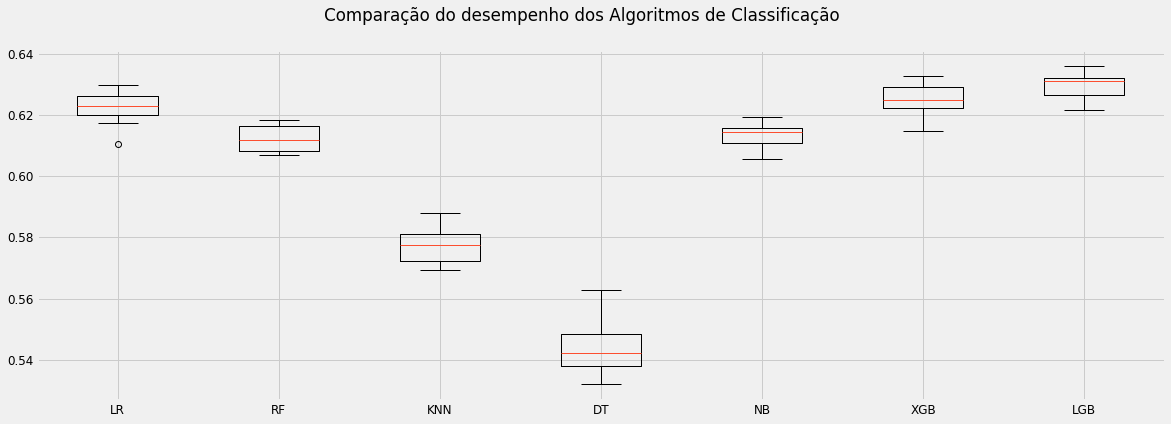

In [9]:
# Boxplot para comparar os algoritmos
fig = plt.figure(figsize = (18, 6))

fig.suptitle('Comparação do desempenho dos Algoritmos de Classificação')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(nomes)
plt.show()

## Realizando Otimização de Hyperparametros no modelo Linear Regression

In [132]:
# Aplicando engenharia de atributos no dataset
train = feature_engineering(df)

# Vamos armazenar 'readmitted' no rótulo (y) e o restante das colunas em X
y = train['readmitted']
X = train.drop(['readmitted'], axis = 1)

# Vamos criar variáveis dummy para variáveis categóricas
X = pd.get_dummies(X)

# Split dos dados
X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, y, test_size = .2, random_state = 0, stratify = y)

# Cria o padronizador
scaler = StandardScaler()

# Padronizando os dados
X_treino_scaled = scaler.fit_transform(X_treino)

# Nos dados de teste, aplicamos apenas o transform()
X_teste_scaled = scaler.transform(X_teste)

# Aplicar o balanceamento de classes usando SMOTE
new_X, new_y = balanceamento_classe(X_treino_scaled, Y_treino)

In [134]:
# Cria o modelo
model_lr = LogisticRegression(tol = 1e-7, penalty = 'l2', C = 0.0005, solver = 'liblinear')

# Treina o modelo
model_lr.fit(new_X, new_y)

# Faz as previsões
lr_y_pred = model_lr.predict(X_teste_scaled)

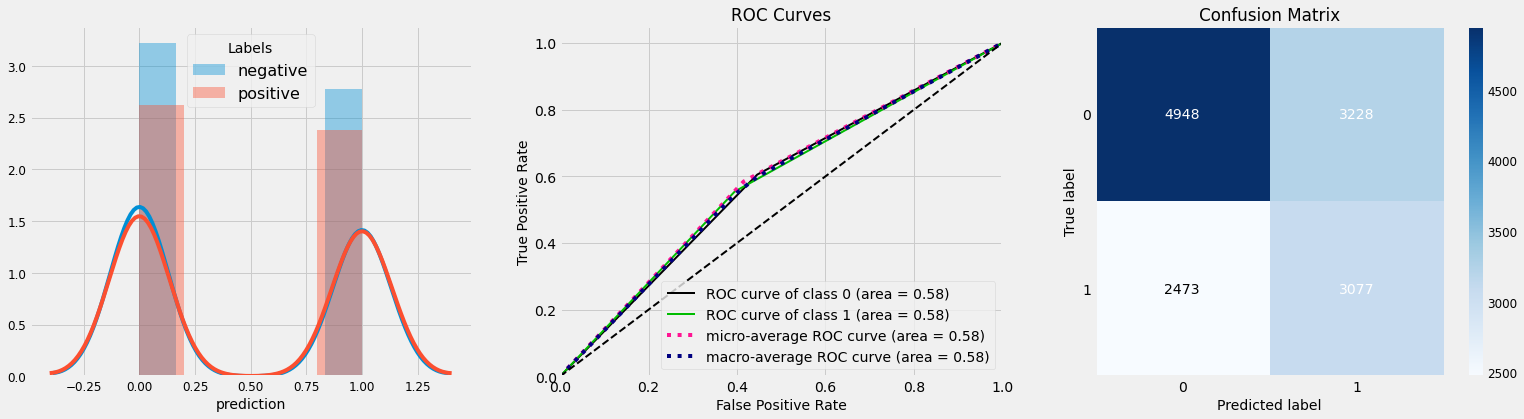

In [135]:
def plot_prediction_distribution(y_true, y_pred, ax):
    df = pd.DataFrame({'prediction': y_pred, 'original': y_true})    
    sns.distplot(df[df['original'] == 0]['prediction'], label='negative', ax=ax)
    sns.distplot(df[df['original'] == 1]['prediction'], label='positive', ax=ax)
    ax.legend(prop={'size': 16}, title = 'Labels')
    
preds = pd.DataFrame(lr_y_pred, columns=['pos_preds'])
preds['neg_preds'] = 1.0 - preds['pos_preds']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24, 6))

plot_prediction_distribution(Y_teste, preds['pos_preds'], ax=ax1);

plot_roc(Y_teste, preds[['neg_preds','pos_preds']], ax=ax2);

plot_confusion_matrix(Y_teste, lr_y_pred > 0.5, ax=ax3);

In [139]:
# Converte as probabilidades em classe
lr_t_y_pred = (lr_y_pred > 0.5)

# Agora convertemos os valores booleanos em classe binária, 0 ou 1
lr_t_y_pred = np.where(lgb_t_pred == 'True', 1, lr_t_y_pred)

# Cria e imprime a matriz de confusão
conf_matriz_lr = confusion_matrix(Y_teste, lr_t_y_pred)

# Calcula o total 
total1 = sum(sum(conf_matriz_lr))

# Calcula a acurácia
accuracy_lr = (conf_matriz_lr[0,0] + conf_matriz_lr[1,1]) / total1
    
# Calcula especificidade e sensibilidade
sensi_lr = conf_matriz_lr[1,1] / (conf_matriz_lr[1,0] + conf_matriz_lr[1,1])
speci_lr = conf_matriz_lr[0,0] / (conf_matriz_lr[0,0] + conf_matriz_lr[0,1])

# Print
print('Sensibilidade :', sensi_lr)
print('Especificidade :', speci_lr)

# Calcula o score com dados de teste
lr_accuracy = model_lr.score(X_teste_scaled, Y_teste) * 100

# Print
print("\nAcurácia do Modelo de Regressão Logística (%):", lr_accuracy)
print("\n")

# Relatório de Classificação
print(classification_report(Y_teste, lr_y_pred, target_names = ['Não', 'Sim']))

Sensibilidade : 0.5544144144144144
Especificidade : 0.6051859099804305

Acurácia do Modelo de Regressão Logística (%): 58.46568556025063


              precision    recall  f1-score   support

         Não       0.67      0.61      0.63      8176
         Sim       0.49      0.55      0.52      5550

    accuracy                           0.58     13726
   macro avg       0.58      0.58      0.58     13726
weighted avg       0.59      0.58      0.59     13726



/home/unimed/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


## Realizando Otimização de Hyperparametros no modelo LightGBM

In [137]:
# Aplicando engenharia de atributos no dataset
train = feature_engineering(df)

# Vamos armazenar 'readmitted' no rótulo (y) e o restante das colunas em X
y = train['readmitted']
X = train.drop(['readmitted'], axis = 1)

# Vamos criar variáveis dummy para variáveis categóricas
X = pd.get_dummies(X)

# Split dos dados
X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, y, test_size = .2, random_state = 0, stratify = y)

# Cria o padronizador
scaler = StandardScaler()

# Padronizando os dados
X_treino_scaled = scaler.fit_transform(X_treino)

# Nos dados de teste, aplicamos apenas o transform()
X_teste_scaled = scaler.transform(X_teste)

# Aplicar o balanceamento de classes usando SMOTE
new_X, new_y = balanceamento_classe(X_treino_scaled, Y_treino)

In [140]:
# Definindo os hyperparametros do modelo
params = {
         'boosting_type'           : 'gbdt',
         'metric'                  : 'auc',
         'objective'               : 'binary',
         'learning_rate'           : 0.01,
         'max_depth'               : -1,
         'max_bin'                 : 500,
         'min_data_in_leaf'        : 260,
         'min_sum_hessian_in_leaf' : 10.0,
         'num_leaves'              : 10,
         'bagging_fraction'        : 0.95,
         'feature_fraction'        : 0.98,
         'bagging_freq'            : 6,
         'is_unbalance'            : True,
         'verbosity'               : 1
       }


# Realizacao do treinamento do modelo para cada Kfold definido
models = []
num_boost_round = 50000
folds = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(new_X, new_y)):

    print("Fold {}".format(fold_))

    trn_data = lgb.Dataset(new_X[trn_idx], label=new_y[trn_idx])
    val_data = lgb.Dataset(new_X[val_idx], label=new_y[val_idx])

    clf = lgb.train(params, 
                    trn_data, 
                    num_boost_round, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval = 1000, 
                    early_stopping_rounds = 500)

    models.append(clf)          

Fold 0
Training until validation scores don't improve for 500 rounds
[1000]	training's auc: 0.765362	valid_1's auc: 0.747977
[2000]	training's auc: 0.781773	valid_1's auc: 0.752405
[3000]	training's auc: 0.792598	valid_1's auc: 0.752744
Early stopping, best iteration is:
[2630]	training's auc: 0.788945	valid_1's auc: 0.752955
Fold 1
Training until validation scores don't improve for 500 rounds
[1000]	training's auc: 0.763809	valid_1's auc: 0.748726
[2000]	training's auc: 0.779613	valid_1's auc: 0.752592
[3000]	training's auc: 0.789897	valid_1's auc: 0.75292
Early stopping, best iteration is:
[2718]	training's auc: 0.787246	valid_1's auc: 0.753034


In [141]:
def predict(x_te, models):
    model_num = len(models)
    for k,m in enumerate(models):
        if k==0:
            y_pred = m.predict(x_te,num_iteration=m.best_iteration)
        else:
            y_pred += m.predict(x_te,num_iteration=m.best_iteration)
    y_pred = y_pred / model_num
    return y_pred

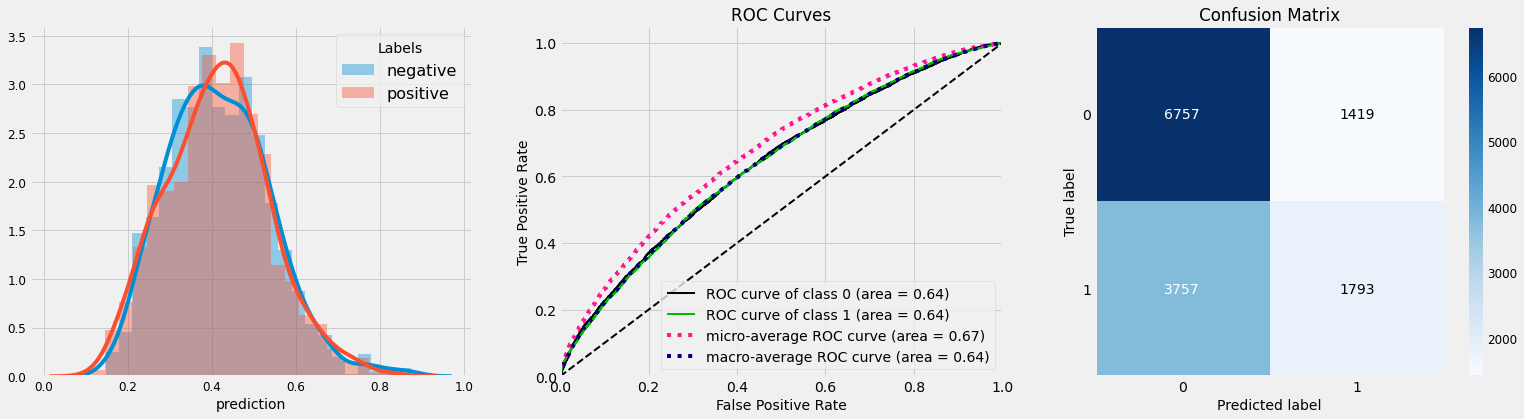

In [142]:
# Faz as previsões
lgb_y_pred = predict(X_teste_scaled, models)

preds = pd.DataFrame(lgb_y_pred, columns=['pos_preds'])
preds['neg_preds'] = 1.0 - preds['pos_preds']

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24, 6))

plot_prediction_distribution(Y_teste, preds['pos_preds'], ax=ax1);

plot_roc(Y_teste, preds[['neg_preds','pos_preds']], ax=ax2);

plot_confusion_matrix(Y_teste, lgb_y_pred > 0.5, ax=ax3);

In [143]:
# Converte as probabilidades em classe
lgb_t_y_pred = (lgb_y_pred > 0.5)

# Agora convertemos os valores booleanos em classe binária, 0 ou 1
lgb_t_y_pred = np.where(lgb_t_y_pred == 'True', 1, lgb_t_y_pred)

# Cria e imprime a matriz de confusão
conf_matriz_lgb = confusion_matrix(Y_teste, lgb_t_y_pred)

# Calcula o total 
total1 = sum(sum(conf_matriz_lgb))

# Calcula a acurácia
accuracy_lgb = (conf_matriz_lgb[0,0] + conf_matriz_lgb[1,1]) / total1
    
# Calcula especificidade e sensibilidade
sensi_lgb = conf_matriz_lgb[1,1] / (conf_matriz_lgb[1,0] + conf_matriz_lgb[1,1])
speci_lgb = conf_matriz_lgb[0,0] / (conf_matriz_lgb[0,0] + conf_matriz_lgb[0,1])

# Print
print('Sensibilidade :', sensi_lgb)
print('Especificidade :', speci_lgb)

# Calcula ROC AUC
roc_auc_oof = roc_auc_score(Y_teste, lgb_y_pred)

# Print
print("\nAcurácia do Modelo LightGBM (%):", roc_auc_oof)
print("\n")

# Relatório de Classificação
print(classification_report(Y_teste, lgb_t_y_pred, target_names = ['Não', 'Sim']))

Sensibilidade : 0.32306306306306304
Especificidade : 0.8264432485322897

Acurácia do Modelo LightGBM (%): 0.6384369545670915


              precision    recall  f1-score   support

         Não       0.64      0.83      0.72      8176
         Sim       0.56      0.32      0.41      5550

    accuracy                           0.62     13726
   macro avg       0.60      0.57      0.57     13726
weighted avg       0.61      0.62      0.60     13726



/home/unimed/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


## Comparação Entre os Modelos

Text(0, 0.5, 'Taxa de Verdadeiro Positivo')

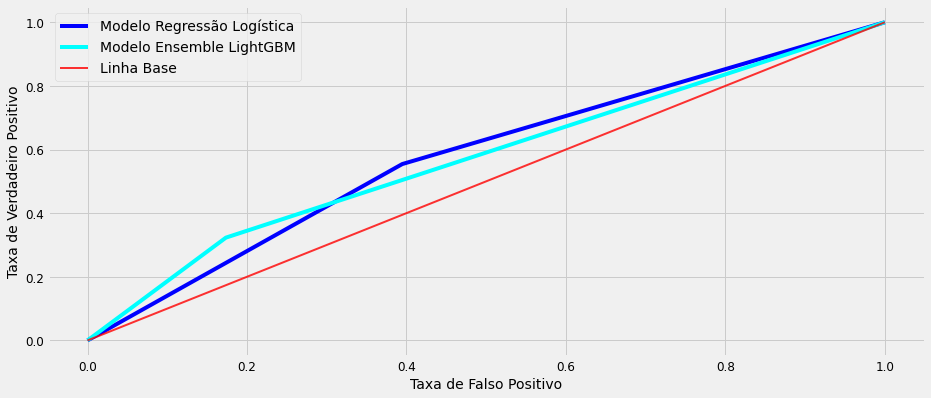

In [148]:
# Extrai as métricas para a Curva ROC (aqui usamos as previsões das probabilidades)
lr_fpr, lr_tpr, thresholds = roc_curve(Y_teste, lr_t_y_pred)

# Extrai as métricas para a Curva ROC (aqui usamos as previsões das probabilidades)
lgb_fpr, lgb_tpr, thresholds = roc_curve(Y_teste, lgb_t_y_pred)

# Comparação via Curva ROC
plt.plot(lr_fpr, lr_tpr, label = 'Modelo Regressão Logística',color = 'blue')
plt.plot(lgb_fpr, lgb_tpr, label = 'Modelo Ensemble LightGBM', color = 'cyan')


# Cria a linha base (linha tracejada em vermelho)
plt.plot([0, 1], [0, 1], linestyle = '-', lw = 2, color = 'r', label = 'Linha Base', alpha = .8)

# Plot
plt.legend()
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')

## Observação Final

Em ambos os modelos testados, o recall (sensibilidade) está baixo, o que significa que os modelos tiveram dificuldades de prever a classe positiva (sim), ou seja, quando o paciente foi readmitido.

O ideal é um equilíbrio entre sensibilidade e especificidade.

E, apesar do modelo LightGBM apresentar uma acurácia global melhor, com 64%, o modelo selecionado para realizar as novas previsões será o modelo Linear Regression, considerando que obteve um desempenho geral de 58% porém, com um maior valor para o recall (sensibilidade), o que é importante para esse problema de negócio.

A **sensibilidade** (também chamada de taxa de verdadeiros positivos, recall ou probabilidade de detecção em alguns campos) mede a proporção de positivos reais que são corretamente identificados como tais (por exemplo, a porcentagem de pessoas doentes corretamente identificadas como tendo o doença).

A **especificidade** (também chamada de taxa de verdadeiros negativos) mede a proporção de negativos reais que são identificados corretamente como tal (por exemplo, a porcentagem de pessoas saudáveis que são identificadas corretamente como sem a condição).

Em muitos testes, incluindo exames médicos de diagnóstico, a sensibilidade é a extensão em que os positivos reais não são negligenciados (os falsos negativos são poucos) e a especificidade é a extensão em que os negativos reais são classificados como tais (os falsos positivos são poucos). 

Assim, um teste altamente sensível raramente ignora um positivo real (por exemplo, mostrando "nada de ruim", apesar de existir algo ruim); um teste altamente específico raramente registra uma classificação positiva para qualquer coisa que não seja o objetivo do teste (por exemplo, encontrar uma espécie bacteriana e confundi-la com outra intimamente relacionada que é o verdadeiro alvo); e um teste que é altamente sensível e altamente específico faz as duas coisas.

A sensibilidade, portanto, quantifica a prevenção de falsos negativos e a especificidade faz o mesmo com os falsos positivos. Para qualquer teste, geralmente há uma troca entre as medidas - por exemplo, na segurança do aeroporto, já que o teste de passageiros é para ameaças à segurança, os scanners podem ser configurados para acionar alarmes em itens de baixo risco, como fivelas de cinto e chaves (baixa especificidade) para aumentar a probabilidade de identificação de objetos perigosos e minimizar o risco de objetos ausentes que representam uma ameaça (alta sensibilidade). 

Esse trade-off pode ser representado graficamente usando uma curva de característica operacional do receptor (Curva ROC). Um preditor perfeito seria descrito como 100% sensível, o que significa que todos os indivíduos doentes são corretamente identificados como doentes e 100% específico, o que significa que nenhum indivíduo saudável é identificado incorretamente como doente. Na realidade, no entanto, qualquer preditor não determinístico possuirá um limite de erro mínimo conhecido como taxa de erro de Bayes. Os valores de sensibilidade e especificidade são agnósticos ao percentual de casos positivos na população de interesse (em oposição a, por exemplo, precisão).

Referências:

<a href="https://www.healthnewsreview.org/toolkit/tips-for-understanding-studies/understanding-medical-tests-sensitivity-specificity-and-positive-predictive-value/">Understanding medical tests: sensitivity, specificity, and positive predictive value</a>

## Estratificação de Risco

In [152]:
lr_y_pred

array([0, 1, 1, ..., 1, 1, 0])

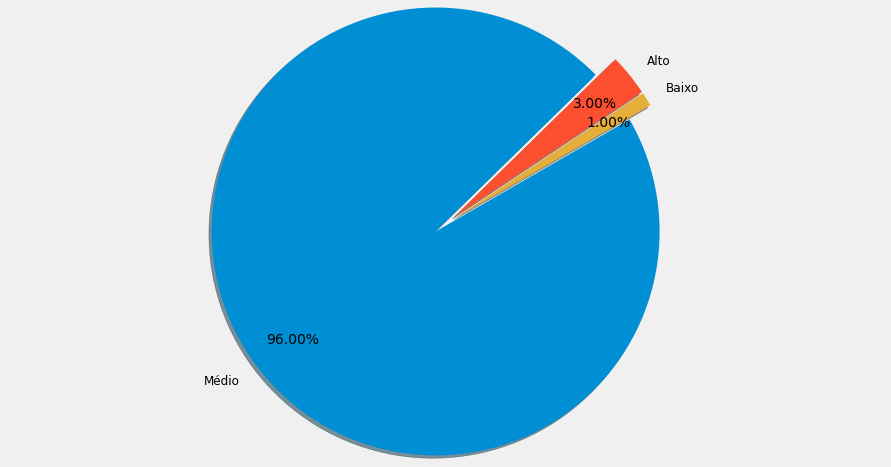

In [155]:
# Função para estratificar o risco
def classifica_risco(row):
    if row[0] <= 0.3 : return 'Baixo'
    if row[0] >= 0.7 : return 'Alto'
    return 'Médio'


# Probabilidades Previstas (em dados de teste)
lr_predict_proba = model_lr.predict_proba(X_teste_scaled)[:,1] 

# Dataframe com as probabilidades previstas (em dados de teste)
df_proba = pd.DataFrame(lr_predict_proba, columns = ['Probabilidade'])

# Dataframe para o risco estratificado
df_risco = pd.DataFrame()

# Agora carregamos o dataframe
df_risco['Risco'] = df_proba.apply(classifica_risco, axis = 1)

# Vamos separar em percentual
percentual = round(df_risco.Risco.value_counts() / len(df_risco.index) * 100, 1)

# Legenda para o gráfico
sub = ['Médio', 'Alto', 'Baixo']

# Plot
plt.axis("equal")
plt.pie(percentual , 
        labels = sub, 
        radius = 1.6,
        autopct = '%1.2f%%',
        explode = [0.09,0.09,0.09],
        startangle = 30,
        shadow = True,
        counterclock = False,
        pctdistance = 0.8)

plt.show()